# Session 08. 지도학습2
## Random Foreset


In [25]:
 import numpy as np 
import pandas as pd 
import os

In [26]:
df = pd.read_csv("AB_NYC_2019.csv")

In [27]:
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


뉴욕의 에어비엔비 데이터셋을 활용하여 방 타입, 숙박 가격, 최소숙박일수, 최근리뷰, 월 리뷰갯수 등으로부터 숙소의 위치를 알아내는 모델

편의상 맨하튼, 브루클린의 숙소들로 범위를 좁혔습니다

In [28]:
# 브루클린, 맨하튼 숙소만 해볼거니까 이거만 추림
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])]
df.shape, our_set.shape,

((48895, 16), (41765, 16))

### 전체적인 가격대 분포 살펴보기

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Ratio')

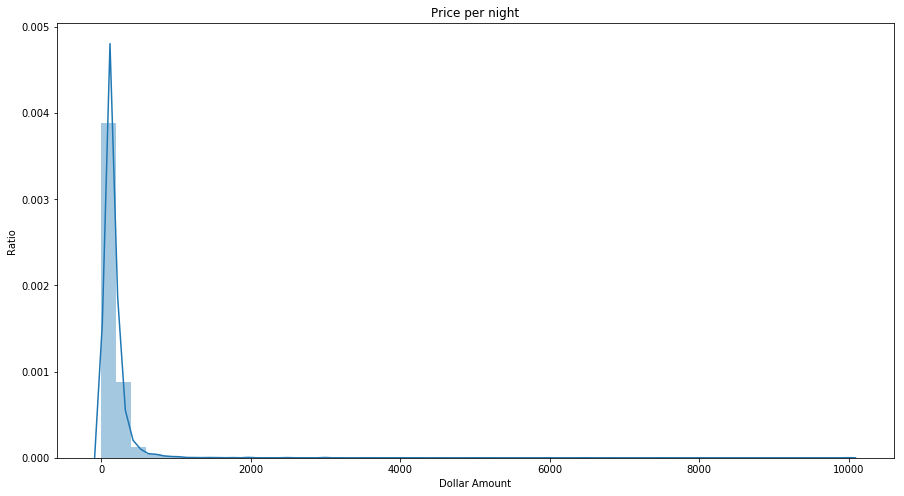

In [30]:
plt.figure(figsize=(15,8))
sns.distplot(our_set['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

Text(0, 0.5, 'Ratio')

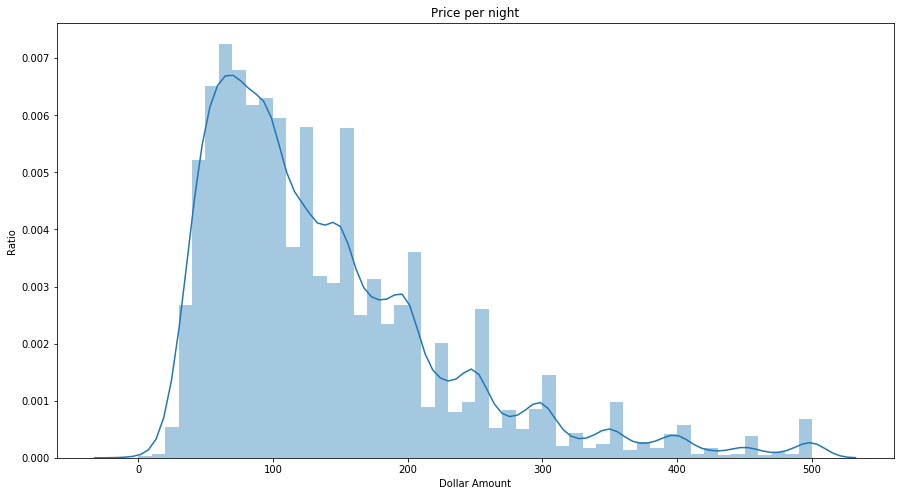

In [31]:
plt.figure(figsize=(15,8))
sns.distplot(our_set[our_set['price']<=500]['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

### 방 타입에는 어떤 것들이 있나...

In [32]:
set(our_set['room_type'])

{'Entire home/apt', 'Private room', 'Shared room'}

### 원핫인코딩: 자연어를 기계가 알아들을 수 있게 수치로 변환
성별이 M, F / 학생이 초/중/고/대 이런식으로 나누어져있으면 이걸 그대로 컬럼으로 놓고 기계한테 학습하라 할 수 없음 --> 숫자로 바꿔야함


그러나 초/중/고/대를 1,2,3,4로 해버리기엔 무리가 있음. 대가 중보다 2배 더 크다? 라고 기계가 오해할 수 있다.


그래서 원핫인코딩!


학교라는 컬럼을 초/중/고/대로 넓힘. 초 이면 (1,0,0,0) / 대 이면 (0,0,0,1) 이런식으로. 서로 상관관계가 없다!

### 룸 타입 역시 자연어로 되어있으므로, "원핫인코딩"을 통해 수치로 변환

In [33]:
onehot = pd.get_dummies(our_set['room_type'])
onehot

,Entire home/apt,Private room,Shared room
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
48890,0,1,0
48891,0,1,0
48892,1,0,0
48893,0,0,1


In [34]:
# 핵심 컬럼만 뽑음 + 더미변수까지 결합
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
combined = core_cols.merge(onehot, left_index=True, right_index=True, how='left').reset_index()
combined.head()

,index,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,Brooklyn,149,1,9,0.21,0,1,0
1,1,Manhattan,225,1,45,0.38,1,0,0
2,2,Manhattan,150,3,0,NaN,0,1,0
3,3,Brooklyn,89,1,270,4.64,1,0,0
4,4,Manhattan,80,10,9,0.10,1,0,0


###  결측치 제외

In [35]:
final = combined.drop(columns=['index']).dropna() # 인덱스가 중복되어있으므로 버리고, 편의상 na도 다 버림
final.shape

(33079, 8)

### 예측을 위해 Brooklyn = 0 / Manhattan = 1 로 인코딩

In [36]:
final = final.replace('Brooklyn', 0).replace('Manhattan', 1)  # brooklyn은 0, manhattan은 1로 바꿈

### 최종 데이터프레임

In [37]:
final

,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,149,1,9,0.21,0,1,0
1,1,225,1,45,0.38,1,0,0
3,0,89,1,270,4.64,1,0,0
4,1,80,10,9,0.10,1,0,0
5,1,200,3,74,0.59,1,0,0
...,...,...,...,...,...,...,...,...
41615,0,45,1,2,2.00,0,1,0
41638,1,150,4,1,1.00,1,0,0
41645,0,550,3,1,1.00,1,0,0
41679,1,129,1,1,1.00,0,1,0


In [38]:
bk = len(final[final['neighbourhood_group']==0])
mh = len(final[final['neighbourhood_group']==1])
tt = len(final)
print(bk, mh, tt) # 브루클린 건은 16447, 맨하탄 건은 16632건, 총 33079건

16447 16632 33079


### 본격적인 모델링

In [50]:
import random
random_seed = 777

In [51]:
### 랜덤 시드를 활용하여 트레인, 테스트셋 분리 / 3:1 비율로

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=random_seed)

In [1]:
### 랜덤포레스트 모델 수립, 대충 하이퍼 파라미터 제공
import time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, oob_score=True, random_state=random_seed) #n_estimators는 나무의 개수

### 학습 진행

t0 = time.time() # 학습 시작때 시간
rf.fit(X_train, y_train)

elapsed = time.time()-t0 # 학습 끝났을때 시간 - 학습 끝난 시간
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

NameError: name 'random_seed' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

### 학습된 모델로 분류 예측
prediction = rf.predict(X_test)
### 채점
accuracy = accuracy_score(y_test, prediction)
### 성적 발표
print(f'Mean accuracy score: {100*accuracy:.3}%')

### Random Forest의 변수 중요도 파악


In [56]:
best_cols_values = rf.feature_importances_

best_cols = pd.Series(best_cols_values, index=X_train.columns)
top20_cols = best_cols.sort_values(ascending=False)[:10]
top20_cols                                         

reviews_per_month    0.343121
price                0.320907
number_of_reviews    0.229111
minimum_nights       0.106861
dtype: float64

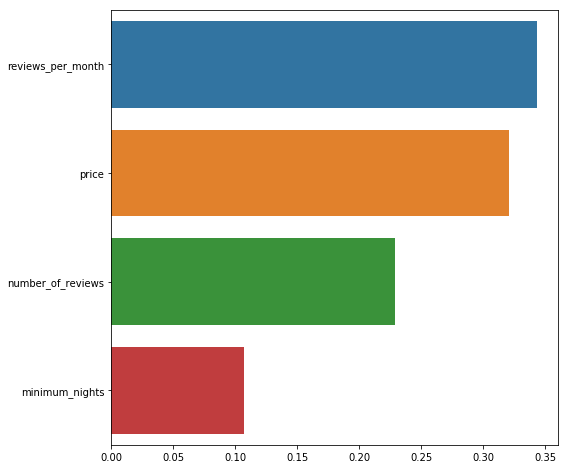

In [57]:
# 변수중요도를 시각화해보자
plt.figure(figsize=(8,8))
sns.barplot(x=top20_cols, y=top20_cols.index)
plt.show()

# ★퀘스트★

### 오늘 배운 모델들을 활용하여 (DT, SVM, XGBOOST / RF는 제외!!) 이보다 더 정교한 모델을 만들어보아요.
### 목표는 정확도 > 63%

(+추가)
같은 모델이더라도, 하이퍼 파라미터를 바꿔가며 코드를 실행해보면 결과가 달라집니다. 예를 들어 RF에서 나무의 개수!

또는 모델에 들어갈 x 변수를 더 늘리거나 줄여도 성능이 달라집니다.

time 모듈을 활용하여 각 모델별로 걸리는 시간도 측정해보세요.

모르는 게 있으면 질문해주세요!